In [180]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import time
import datetime
from datetime import datetime, date,timedelta
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import preprocessing, svm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,explained_variance_score
import sklearn
import matplotlib 
import matplotlib.pyplot as plt 
import matplotlib.dates as dates
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline
matplotlib.style.use('ggplot')


In [181]:
#Get the Data
owid_covid_data = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv')
owid_covid_data.head()

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand
0,AFG,Asia,Afghanistan,2019-12-31,0,0,0,0,0.0,0.0,...,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
1,AFG,Asia,Afghanistan,2020-01-01,0,0,0,0,0.0,0.0,...,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
2,AFG,Asia,Afghanistan,2020-01-02,0,0,0,0,0.0,0.0,...,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
3,AFG,Asia,Afghanistan,2020-01-03,0,0,0,0,0.0,0.0,...,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5
4,AFG,Asia,Afghanistan,2020-01-04,0,0,0,0,0.0,0.0,...,2.581,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5


In [182]:
#Select Coloumn to clean
ColumnToClean = ['total_cases', 'new_cases', 'total_deaths', 'new_deaths','aged_65_older','aged_70_older','gdp_per_capita','diabetes_prevalence','female_smokers','male_smokers','hospital_beds_per_thousand']
#Replace the nan with emty string
owid_covid_data[['location']] = owid_covid_data[['location']].fillna('')
#Replace the Nan with 0
owid_covid_data[ColumnToClean] = owid_covid_data[ColumnToClean].fillna(0)
#Filter the data so we will get only overall world data
owid_covid_data = owid_covid_data.query('location=="World"' )
Data_For_Regression = pd.DataFrame(columns=['date','total_cases', 'new_cases', 'total_deaths', 'new_deaths','aged_65_older','aged_70_older','gdp_per_capita','diabetes_prevalence','female_smokers','male_smokers','hospital_beds_per_thousand'], data=owid_covid_data[['date','total_cases', 'new_cases', 'total_deaths', 'new_deaths','aged_65_older','aged_70_older','gdp_per_capita','diabetes_prevalence','female_smokers','male_smokers','hospital_beds_per_thousand']].values)
Data_For_Regression.head()

,date,total_cases,new_cases,total_deaths,new_deaths,aged_65_older,aged_70_older,gdp_per_capita,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand
0,2019-12-31,27,27,0,0,8.696,5.355,15469.2,8.51,6.434,34.635,2.705
1,2020-01-01,27,0,0,0,8.696,5.355,15469.2,8.51,6.434,34.635,2.705
2,2020-01-02,27,0,0,0,8.696,5.355,15469.2,8.51,6.434,34.635,2.705
3,2020-01-03,44,17,0,0,8.696,5.355,15469.2,8.51,6.434,34.635,2.705
4,2020-01-04,44,0,0,0,8.696,5.355,15469.2,8.51,6.434,34.635,2.705


In [183]:
#This code is wriiten under the assumption we don't have an entry for the world data
#Get the sum group by date
#Death_Case_World = owid_covid_data.groupby(['date'])['total_cases','total_deaths','new_cases'].sum()
#Death_Case_World = Death_Case_World.reset_index()
#Get the mean group by date
#Dependant_World = owid_covid_data.groupby(['date'])['aged_65_older','aged_70_older','gdp_per_capita','diabetes_prevalence','female_smokers','male_smokers','hospital_beds_per_thousand'].mean()
#Dependant_World = Dependant_World.reset_index()
#Join the data frames
#Data_For_Regression = pd.concat([Death_Case_World.set_index('date'),Dependant_World.set_index('date')], axis=1, join='inner').reset_index()
#Data_For_Regression.head()

In [184]:
#set the index as date
Data_For_Regression['date'] = pd.to_datetime(Data_For_Regression['date'])
Data_For_Regression = Data_For_Regression.set_index('date')
Data_For_Regression.head()

,total_cases,new_cases,total_deaths,new_deaths,aged_65_older,aged_70_older,gdp_per_capita,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand
date,,,,,,,,,,,
2019-12-31,27,27,0,0,8.696,5.355,15469.2,8.51,6.434,34.635,2.705
2020-01-01,27,0,0,0,8.696,5.355,15469.2,8.51,6.434,34.635,2.705
2020-01-02,27,0,0,0,8.696,5.355,15469.2,8.51,6.434,34.635,2.705
2020-01-03,44,17,0,0,8.696,5.355,15469.2,8.51,6.434,34.635,2.705
2020-01-04,44,0,0,0,8.696,5.355,15469.2,8.51,6.434,34.635,2.705


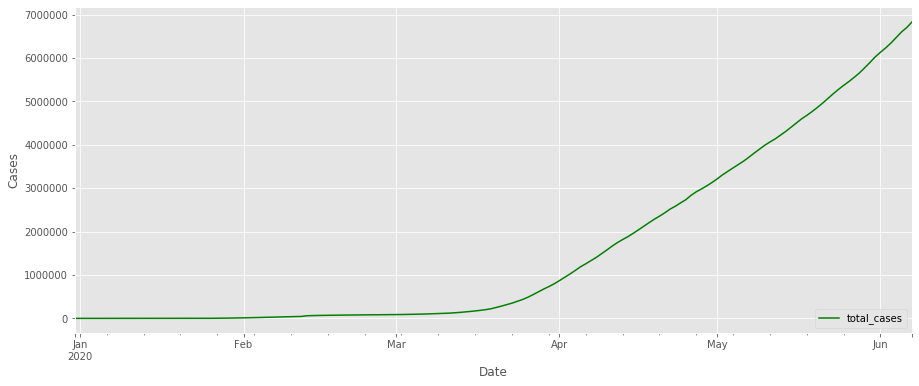

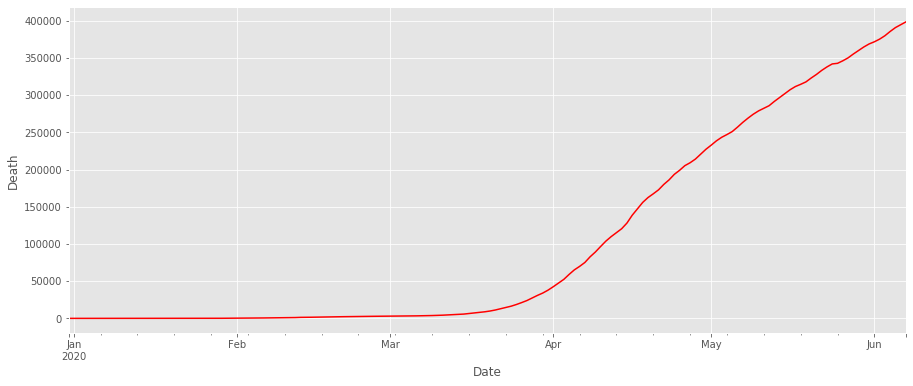

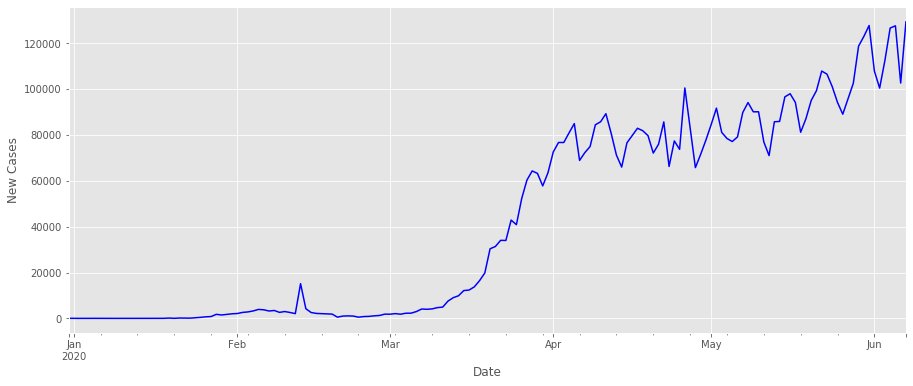

In [185]:
#Plot the graph
Data_For_Regression['total_cases'].plot(figsize=(15,6), color="green")
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Cases')
plt.show()

Data_For_Regression['total_deaths'].plot(figsize=(15,6), color="red")
plt.xlabel('Date')
plt.ylabel('Death')
plt.show()

Data_For_Regression['new_cases'].plot(figsize=(15,6), color="blue")
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.show()

In [186]:
# pick total death as forecast column
forecast_col = 'total_deaths'

# Chosing 30 days as number of forecast days
forecast_out = int(30)
print('length =',len(Data_For_Regression), "and forecast_out =", forecast_out)

length = 160 and forecast_out = 30


In [187]:
# Creating label by shifting 'total_deaths' according to 'forecast_out'
Data_For_Regression['temp'] = Data_For_Regression[forecast_col].shift(-forecast_out)
print(Data_For_Regression.head(2))
print('\n')
# verify rows with NAN in Label column 
print(Data_For_Regression.tail(2))

           total_cases new_cases total_deaths new_deaths aged_65_older  \
date                                                                     
2019-12-31          27        27            0          0         8.696   
2020-01-01          27         0            0          0         8.696   

           aged_70_older gdp_per_capita diabetes_prevalence female_smokers  \
date                                                                         
2019-12-31         5.355        15469.2                8.51          6.434   
2020-01-01         5.355        15469.2                8.51          6.434   

           male_smokers hospital_beds_per_thousand temp  
date                                                     
2019-12-31       34.635                      2.705  170  
2020-01-01       34.635                      2.705  213  


           total_cases new_cases total_deaths new_deaths aged_65_older  \
date                                                                     
2020-06-

In [188]:
# Define features Matrix X by excluding the label column which we just created 
X = np.array(Data_For_Regression.drop(['temp'], 1))

# Using a feature in sklearn, preposessing to scale features
X = preprocessing.scale(X)
print(X[1,:])

[-0.77567628 -0.9983923  -0.76959395 -0.9238417   0.          0.
  0.          0.          0.          0.          0.        ]


In [189]:
# X contains last 'n= forecast_out' rows for which we don't have label data
# Put those rows in different Matrix X_forecast_out by X_forecast_out = X[end-forecast_out:end]

X_forecast_out = X[-forecast_out:]
X = X[:-forecast_out]
print ("Length of X_forecast_out:", len(X_forecast_out), "& Length of X :", len(X))

Length of X_forecast_out: 30 & Length of X : 130


In [190]:
# Define vector y for the data we have prediction for
# make sure length of X and y are identical
y = np.array(Data_For_Regression['temp'])
y = y[:-forecast_out]
print('Length of y: ',len(y))

Length of y:  130


In [191]:
# (split into test and train data)
# test_size = 0.2 ==> 20% data is test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print('length of X_train and x_test: ', len(X_train), len(X_test))

length of X_train and x_test:  104 26


In [192]:
# Create linear regression object
lr = LinearRegression()

# Train the model using the training sets
lr.fit(X_train, y_train)
# Test
accuracy = lr.score(X_test, y_test)
print("Accuracy of Linear Regression: ", accuracy)

Accuracy of Linear Regression:  0.9596423922800923


In [193]:
# Predict using our Model
forecast_prediction = lr.predict(X_forecast_out)
print(forecast_prediction)

[ 450374.24696253  466056.4317576   456907.18648657  454736.35887402
  481598.4634873   493064.20746393  524259.14359801  540202.47657752
  550624.20170533  545452.84057841  571058.42452341  590394.62198027
  614281.9635615   642817.66400772  659720.13233615  669245.47596567
  693261.36844387  689748.38661642  716443.66047255  738530.90828762
  791281.51340419  820077.86823627  856925.73852526  846347.80615014
  848125.85352664  886154.80962613  927888.5473948   953162.17949744
  929425.34767204 1005394.37124224]


In [194]:
Data_For_Regression.tail()

,total_cases,new_cases,total_deaths,new_deaths,aged_65_older,aged_70_older,gdp_per_capita,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,temp
date,,,,,,,,,,,,
2020-06-03,6349294,112519,379991,4560,8.696,5.355,15469.2,8.51,6.434,34.635,2.705,NaN
2020-06-04,6475978,126684,385737,5746,8.696,5.355,15469.2,8.51,6.434,34.635,2.705,NaN
2020-06-05,6603647,127669,390926,5189,8.696,5.355,15469.2,8.51,6.434,34.635,2.705,NaN
2020-06-06,6706334,102687,394714,3788,8.696,5.355,15469.2,8.51,6.434,34.635,2.705,NaN
2020-06-07,6835723,129389,398636,3922,8.696,5.355,15469.2,8.51,6.434,34.635,2.705,NaN


In [195]:

last_date = Data_For_Regression.iloc[-1].name 
last_date

Timestamp('2020-06-07 00:00:00')

In [196]:
todays_date = datetime.strptime(last_date.strftime("%Y-%m-%d"), "%Y-%m-%d")
todays_date = todays_date + timedelta(days=1)
todays_date = datetime.strptime(todays_date.strftime("%Y-%m-%d"), "%Y-%m-%d")
index = pd.date_range(todays_date, periods=30, freq='D')
columns = ['total_cases', 'new_cases', 'total_deaths', 'new_deaths','aged_65_older','aged_70_older','gdp_per_capita','diabetes_prevalence','female_smokers','male_smokers','hospital_beds_per_thousand','temp','forecast']
temp_df = pd.DataFrame(index=index, columns=columns)
temp_df

,total_cases,new_cases,total_deaths,new_deaths,aged_65_older,aged_70_older,gdp_per_capita,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,temp,forecast
2020-06-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [197]:
j=0
for i in forecast_prediction:
    temp_df.iat[j,12] = i
    j= j+1

temp_df

,total_cases,new_cases,total_deaths,new_deaths,aged_65_older,aged_70_older,gdp_per_capita,diabetes_prevalence,female_smokers,male_smokers,hospital_beds_per_thousand,temp,forecast
2020-06-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,450374
2020-06-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,466056
2020-06-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456907
2020-06-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,454736
2020-06-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,481598
2020-06-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,493064
2020-06-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,524259
2020-06-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,540202
2020-06-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,550624
2020-06-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,545453


In [198]:
#Append the forcasted - Initially did it for easness but kater decided to use xgboost also
#Data_For_Regression = Data_For_Regression.append(temp_df)
#Data_For_Regression.tail(40)

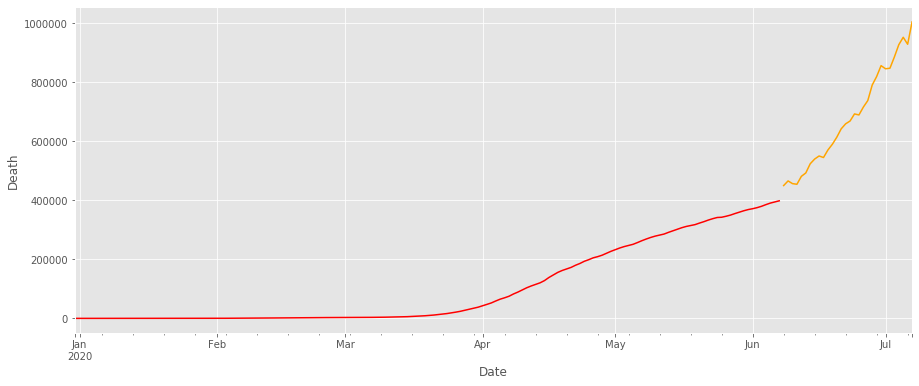

In [199]:
Data_For_Regression['total_deaths'].plot(figsize=(15,6), color="red")
temp_df['forecast'].plot(figsize=(15,6), color="orange")
plt.xlabel('Date')
plt.ylabel('Death')
plt.show()

In [210]:
#  XGboost algorithm to see if we can get better results



xgb_model = xgb.XGBRegressor(objective ='reg:squarederror',colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6) 

traindf, testdf = train_test_split(X_train, test_size = 0.2)

xgb_model.fit(X_train,y_train)


xgforecast_prediction = xgb_model.predict(X_forecast_out)


xgforecast_prediction

array([398349.66, 399729.4 , 378587.94, 373893.47, 396148.53, 395270.6 ,
       398080.12, 397812.4 , 399293.72, 376390.  , 378630.78, 397709.53,
       399164.28, 398383.03, 399164.28, 391069.56, 374272.22, 378352.8 ,
       390755.8 , 397812.4 , 399164.28, 399164.28, 391069.56, 379141.4 ,
       381907.72, 399151.72, 398636.44, 397818.03, 389225.8 , 390755.8 ],
      dtype=float32)

In [211]:
#Setting the temperory df with XGboost forecasted data
j=0
for i in xgforecast_prediction:
    temp_df.iat[j,12] = i
    j= j+1


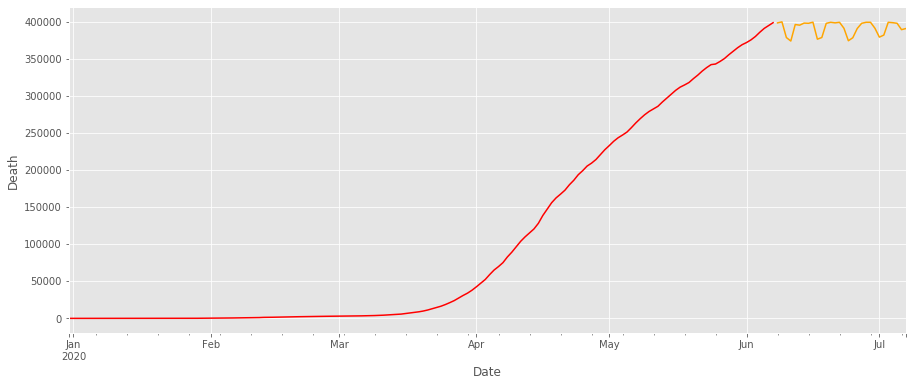

In [212]:
Data_For_Regression['total_deaths'].plot(figsize=(15,6), color="red")
temp_df['forecast'].plot(figsize=(15,6), color="orange")
plt.xlabel('Date')
plt.ylabel('Death')
plt.show()